In [168]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap # plot on map projections
import cartopy.crs as ccrs
import cmaps
import frykit._artist as fa

2D spatial projection of convectively coupled equatorial wave (CCEWs) using parabolic cylinder functions (PCFs) following Yang et al., (2003). 

Parabolic Cylinder Functions (PCFs) are the meridional basis of solutions of the rotating, linearized shallow-water equations on the tropical β-plane




加载数据，包含三个变量，风速、位势高度

In [169]:
ds1 = xr.open_dataset('I:/u.850.20N-20S.0-360.20160101-20201231.nc')
ds2 = xr.open_dataset('I:/v.850.20N-20S.0-360.20160101-20201231.nc')
ds3 = xr.open_dataset('I:/phi.850.20N-20S.0-360.20160101-20201231.nc')

ds1


<xarray.Dataset> Size: 18MB
Dimensions:  (X: 144, T: 1827, Y: 17)
Coordinates:
  * X        (X) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * T        (T) datetime64[ns] 15kB 2016-01-01T12:00:00 ... 2020-12-31T12:00:00
  * Y        (Y) float32 68B 20.0 17.5 15.0 12.5 ... -12.5 -15.0 -17.5 -20.0
Data variables:
    u        (T, Y, X) float32 18MB ...

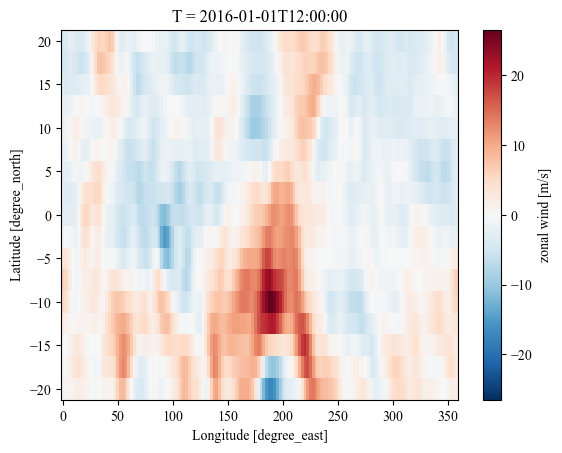

In [170]:
ds1.u.isel(T=0).plot()

In [171]:
np.sum(np.isnan(ds1.u.values))

0

In [172]:

u = ds1.u
v = ds2.v
z = ds3.phi

去除线性趋势，保留波动的特征

In [173]:

u.values = signal.detrend(u.values, axis=0)
v.values = signal.detrend(v.values, axis=0)
z.values = signal.detrend(z.values, axis=0)


进行FFT变换，在变换之前为了防止滤波造成的边界效应，加上一个窗口

In [174]:
wgt_taper = signal.windows.tukey(u.shape[0], alpha=0.1)
wgt_taper

array([0.        , 0.00029598, 0.00118355, ..., 0.00118355, 0.00029598,
       0.        ])

In [175]:
uT = np.transpose(u.values, (1, 2, 0)) * np.reshape(wgt_taper, (-1, u.shape[0]))
vT = np.transpose(v.values, (1, 2, 0)) * np.reshape(wgt_taper, (-1, u.shape[0]))
zT = np.transpose(z.values, (1, 2, 0)) * np.reshape(wgt_taper, (-1, u.shape[0]))


In [176]:
u.values = np.transpose(uT, (2, 0, 1))
v.values = np.transpose(vT, (2, 0, 1))
z.values = np.transpose(zT, (2, 0, 1))


In [177]:

g     = 9.8  # 重力加速度
beta  = 2.3e-11 # beta系数
radea = 6.371e+06 #地球半径
spd   = 86400.0   #每天的秒数
ww    = 2.0 * np.pi / spd # 每天对应的角频率

latmax = 20.0 # 最大纬度

kmin = 2  # 傅里叶变换分析的波数 2-20 wavenumber
kmax = 20

pmin = 3.0 # 和周期范围 3-30days
pmax = 30.0

In [178]:
# convert trapping scale to meters
y0 = 6.0
y0real = 2.0 * np.pi * radea * y0 / 360.0  # 将纬度转换为弧度

ce = 2.0 * y0real**2 * beta  # 重力波波速，一般为 20m/s

g_on_c = g / ce
c_on_g = ce / g

waves = np.array(['Kelvin', 'WMRG', 'R1', 'R2'])


In [179]:
print(y0real,ce,g_on_c,c_on_g)


667169.5598673524 20.475300194225447 0.4786254612649757 2.0893163463495354


将u、z转换为q，变量转换；
对于lon和time进行快速傅里叶变换

In [180]:
print(q.shape)

(1827, 17, 144)


In [181]:
# transform u,z to q, r using q=z*(g/c) + u; r=z*(g/c) - u 

q = z * g_on_c + u
r = z * g_on_c - u

qf = np.fft.fft2(q, axes=(0, 2))
vf = np.fft.fft2(v, axes=(0, 2))
rf = np.fft.fft2(r, axes=(0, 2))

nf = qf.shape[0]
nlat = qf.shape[1]
nk = qf.shape[2]

频率和波数范围选择,找到符合设定周期范围的索引

In [182]:
# Find frequencies and wavenumbers corresponding to pmin,pmax and kmin,kmax in coeff matrices

f = np.fft.fftfreq(nf)
k = np.fft.fftfreq(nk) * nk

fmin = np.where(f >= 1.0 / pmax)[0][0]
fmax = (np.where(f > 1.0 / pmin)[0][0]) - 1

f1p = fmin
f2p = fmax + 1
f1n = nf - fmax
f2n = nf - fmin + 1

k1p = kmin
k2p = kmax + 1
k1n = nk - kmax
k2n = nk - kmin + 1

抛物线柱函数与模式分解

In [183]:
# Define the parobolic cylinder functions

spi2 = np.sqrt(2.0 * np.pi)
dsq = np.array([spi2, spi2, 2.0 * spi2, 6.0 * spi2])
d = np.zeros((dsq.size, nlat))
y = u.Y.values / y0
ysq = y**2
#  定义抛物线柱函数的标准化因子。
d[0, :] = np.exp(-ysq / 4.0)
d[1, :] = y * d[0, :]
d[2, :] = (ysq - 1.0) * d[0, :]
d[3, :] = y * (ysq - 3.0) * d[0, :]

dlat = np.abs(u.Y.values[1] - u.Y.values[0]) * np.pi / 180.0

qf_Kel = np.zeros((nf, nk), dtype='complex')

qf_mode = np.zeros((dsq.size, nf, nk), dtype='complex')
vf_mode = np.zeros((dsq.size, nf, nk), dtype='complex')
rf_mode = np.zeros((dsq.size, nf, nk), dtype='complex')

In [184]:
# reorder the spectral coefficents to make the latitudes the last dimension

qf = np.transpose(qf, (0, 2, 1))
vf = np.transpose(vf, (0, 2, 1))
rf = np.transpose(rf, (0, 2, 1))

for m in np.arange(dsq.size):
    if m == 0:
        qf_Kel[f1n:f2n, k1p:k2p] = np.sum(qf[f1n:f2n, k1p:k2p, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
        qf_Kel[f1p:f2p, k1n:k2n] = np.sum(qf[f1p:f2p, k1n:k2n, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    
    qf_mode[m, f1n:f2n, k1n:k2n] = np.sum(qf[f1n:f2n, k1n:k2n, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    qf_mode[m, f1p:f2p, k1p:k2p] = np.sum(qf[f1p:f2p, k1p:k2p, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    
    vf_mode[m, f1n:f2n, k1n:k2n] = np.sum(vf[f1n:f2n, k1n:k2n, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    vf_mode[m, f1p:f2p, k1p:k2p] = np.sum(vf[f1p:f2p, k1p:k2p, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    
    rf_mode[m, f1n:f2n, k1n:k2n] = np.sum(rf[f1n:f2n, k1n:k2n, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)
    rf_mode[m, f1p:f2p, k1p:k2p] = np.sum(rf[f1p:f2p, k1p:k2p, :] * d[m, :] * dlat, axis=-1) / (dsq[m] / y0)

uf_wave = np.zeros((waves.size, nf, nlat, nk), dtype='complex')
vf_wave = np.zeros((waves.size, nf, nlat, nk), dtype='complex')
zf_wave = np.zeros((waves.size, nf, nlat, nk), dtype='complex')

for w in np.arange(waves.size):
    if waves[w] == 'Kelvin':
        for j in np.arange(nlat):
            uf_wave[w, :, j, :] = 0.5 * qf_Kel * d[0, j]
            zf_wave[w, :, j, :] = 0.5 * qf_Kel * d[0, j] * c_on_g
    
    if waves[w] == 'WMRG':
        for j in np.arange(nlat):
            uf_wave[w, :, j, :] = 0.5 * qf_mode[1, :, :] * d[1, j]
            vf_wave[w, :, j, :] = 0.5 * vf_mode[0, :, :] * d[0, j]
            zf_wave[w, :, j, :] = 0.5 * qf_mode[1, :, :] * d[1, j] * c_on_g
    
    if waves[w] == 'R1':
        for j in np.arange(nlat):
            uf_wave[w, :, j, :] = 0.5 * (qf_mode[2, :, :] * d[2, j] - rf_mode[0, :, :] * d[0, j])
            vf_wave[w, :, j, :] = 0.5 * vf_mode[1, :, :] * d[1, j]
            zf_wave[w, :, j, :] = 0.5 * (qf_mode[2, :, :] * d[2, j] + rf_mode[0, :, :] * d[0, j]) * c_on_g
    
    if waves[w] == 'R2':
        for j in np.arange(nlat):
            uf_wave[w, :, j, :] = 0.5 * (qf_mode[3, :, :] * d[3, j] - rf_mode[1, :, :] * d[1, j])
            vf_wave[w, :, j, :] = 0.5 * vf_mode[2, :, :] * d[2, j]
            zf_wave[w, :, j, :] = 0.5 * (qf_mode[3, :, :] * d[3, j] + rf_mode[1, :, :] * d[1, j]) * c_on_g

In [185]:
u_Kelvin = xr.DataArray(np.real(np.fft.ifft2(uf_wave[0, :, :, :], axes=(0, 2))), coords=[ds1.T, ds1.Y, ds1.X], dims=['T', 'Y', 'X'], name='u')
v_Kelvin = xr.DataArray(np.real(np.fft.ifft2(vf_wave[0, :, :, :], axes=(0, 2))), coords=[ds1.T, ds1.Y, ds1.X], dims=['T', 'Y', 'X'], name='v')
z_Kelvin = xr.DataArray(np.real(np.fft.ifft2(zf_wave[0, :, :, :], axes=(0, 2))), coords=[ds1.T, ds1.Y, ds1.X], dims=['T', 'Y', 'X'], name='z')

u_Kelvin.attrs['long_name'] = 'Kelvin Waves in 850 hPa Zonal Wind'
v_Kelvin.attrs['long_name'] = 'Kelvin Waves in 850 hPa Meridional Wind'
z_Kelvin.attrs['long_name'] = 'Kelvin Waves in 850 hPa Geopotential Height'

u_Kelvin.attrs['units'] = 'm/s'
v_Kelvin.attrs['units'] = 'm/s'
z_Kelvin.attrs['units'] = 'm'

u_R1 = xr.DataArray(np.real(np.fft.ifft2(uf_wave[2, :, :, :], axes=(0, 2))), coords=[ds1.T, ds1.Y, ds1.X], dims=['T', 'Y', 'X'], name='u')
v_R1 = xr.DataArray(np.real(np.fft.ifft2(vf_wave[2, :, :, :], axes=(0, 2))), coords=[ds1.T, ds1.Y, ds1.X], dims=['T', 'Y', 'X'], name='v')
z_R1 = xr.DataArray(np.real(np.fft.ifft2(zf_wave[2, :, :, :], axes=(0, 2))), coords=[ds1.T, ds1.Y, ds1.X], dims=['T', 'Y', 'X'], name='z')

u_R1.attrs['long_name'] = 'n = 1 Equatorial Rossby Waves in 850 hPa Zonal Wind'
v_R1.attrs['long_name'] = 'n = 1 Equatorial Rossby Waves in 850 hPa Meridional Wind'
z_R1.attrs['long_name'] = 'n = 1 Equatorial Rossby Waves in 850 hPa Geopotential Height'

u_R1.attrs['units'] = 'm/s'
v_R1.attrs['units'] = 'm/s'
z_R1.attrs['units'] = 'm'

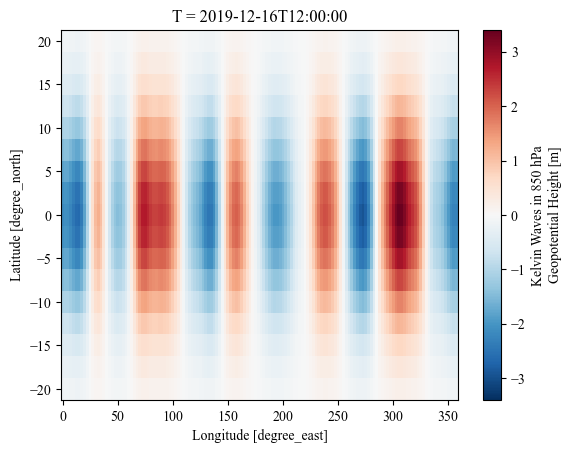

In [186]:
# plot_kelvin wave 

z_Kelvin.sel(T='2019-12-16').plot()

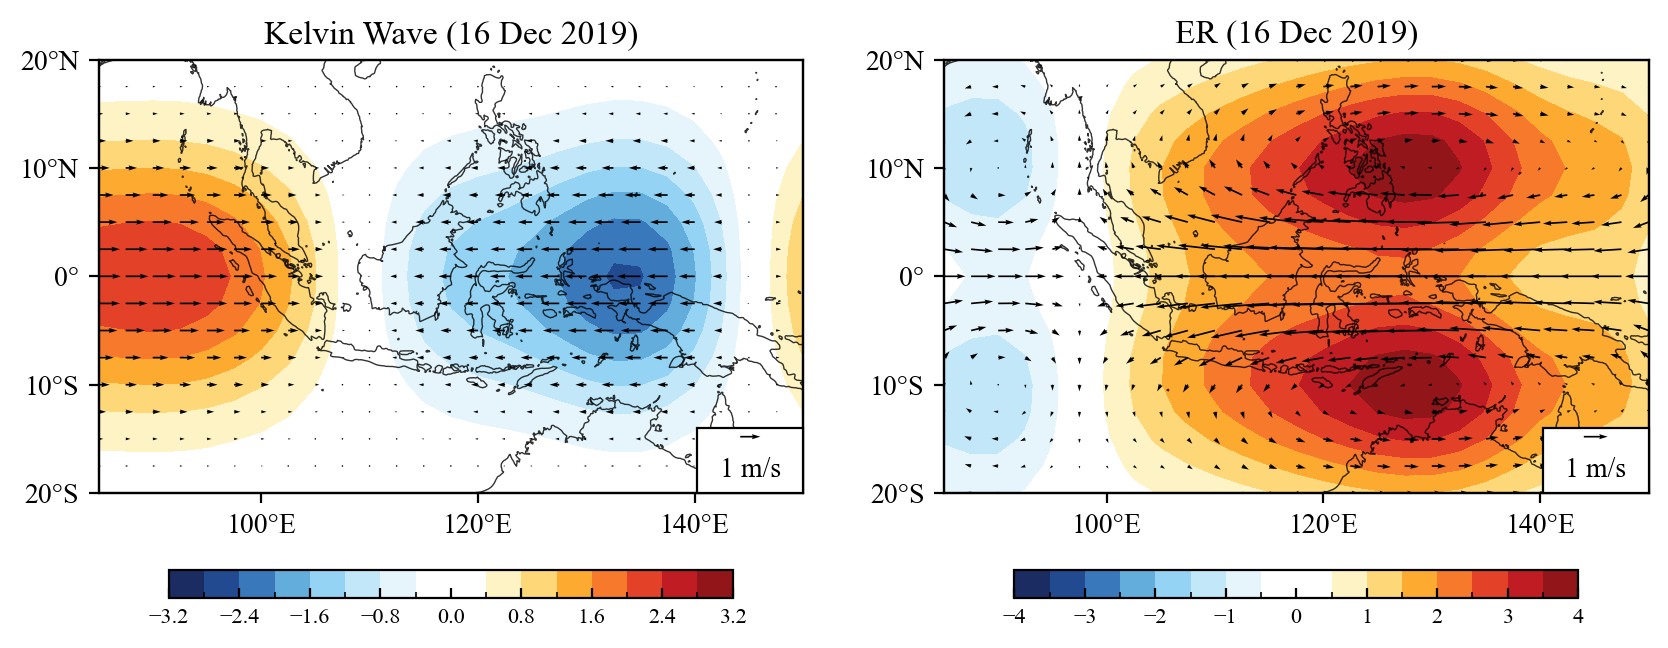

In [187]:

def set_ax(ax, proj):
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    import matplotlib.ticker as mticker
    import matplotlib.ticker as ticker     
    
    import cartopy.feature as cfeature
    
    xstep, ystep = 6, 6
    box = [85, 150, -20, 20]
    ax.set_xlim(box[0], box[1])
    ax.set_ylim(box[2], box[3])
    ax.set_xticks(np.linspace(box[0], box[1], int((box[1] - box[0]) / xstep) + 1), crs=proj)
    ax.set_yticks(np.linspace(box[2], box[3], int((box[3] - box[2]) / ystep) + 1), crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.xaxis.set_major_locator(mticker.MultipleLocator(20))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.spines[['right', 'left', 'top', 'bottom']].set_linewidth(0.8)
    ax.spines[['right', 'left', 'top', 'bottom']].set_visible(True)
   
u_Kelvin_1 = u_Kelvin.sel(X=slice(40, 150), Y=slice( 20,-20),T='2019-12-16')
v_Kelvin_1 = v_Kelvin.sel(X=slice(40, 150), Y=slice( 20,-20),T='2019-12-16')
z_Kelvin_1 = z_Kelvin.sel(X=slice(40, 150), Y=slice( 20,-20),T='2019-12-16')

u_R1_1 = u_R1.sel(X=slice(40, 150), Y=slice( 20,-20),T='2019-12-16')
v_R1_1 = v_R1.sel(X=slice(40, 150), Y=slice( 20,-20),T='2019-12-16')
z_R1_1 = z_R1.sel(X=slice(40, 150), Y=slice( 20,-20),T='2019-12-16')

lons=u_Kelvin_1.X.values
lats=u_Kelvin_1.Y.values
data=z_Kelvin_1[0]
data2=z_R1_1[0]
plt.rcParams['font.sans-serif'] = ['Times New Roman']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=200,
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})


cf = data.plot.contourf(ax=ax1,  cmap=cmaps.BlueWhiteOrangeRed, transform=ccrs.PlateCarree(), 
                     levels=np.linspace(-3.2, 3.2, 17),add_colorbar=False,add_labels=False
                     )
Q=ax1.quiver(lons, lats, u_Kelvin_1[0].values, v_Kelvin_1[0].values, transform=ccrs.PlateCarree(),scale=35 )
ax1.coastlines(alpha=0.8,linewidth=0.5)
cbar = plt.colorbar(cf, ax=ax1, orientation='horizontal', pad=0.1,shrink=0.8)
cbar.set_label('')
ax1.set_title('Kelvin Wave (16 Dec 2019)')
cbar.ax.tick_params(labelsize=8,which='both',direction='in')
set_ax(ax1,proj=ccrs.PlateCarree())
quiver_legend1 = fa.QuiverLegend(
        Q=Q,
        U=1,
    )
Q.axes.add_artist(quiver_legend1)
# fplt.add_quiver_legend(Q, U=1)
####### rossby

cf2 = data2.plot.contourf(ax=ax2,  cmap=cmaps.BlueWhiteOrangeRed, transform=ccrs.PlateCarree(), 
                     levels=np.linspace(-4, 4, 17),add_colorbar=False,add_labels=False
                     )
Q2=ax2.quiver(lons, lats, u_R1_1[0].values, v_R1_1[0].values, transform=ccrs.PlateCarree() )
ax2.coastlines(alpha=0.8,linewidth=0.5)
cbar = plt.colorbar(cf2, ax=ax2, orientation='horizontal', pad=0.1,shrink=0.8)
cbar.set_label('')
ax2.set_title('ER (16 Dec 2019)')
cbar.ax.tick_params(labelsize=8,which='both',direction='in')
set_ax(ax2,proj=ccrs.PlateCarree())
quiver_legend2 = fa.QuiverLegend(
        Q=Q2,
        U=1,
    )
Q2.axes.add_artist(quiver_legend2)
plt.show()